In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
import matplotlib.pyplot as plt
import sklearn
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

In [3]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train['far_price'].fillna(0, inplace = True)
train['near_price'].fillna(0, inplace = True)
train.dropna(inplace = True)
train.reset_index(inplace = True)
train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], inplace=True)
train = train.reset_index(drop = True)
train

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,191,0,0,10,1299772.70,1,1.000026,15261106.63,0.000000,0.000000,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
2,382,0,0,20,1299772.70,1,0.999919,15261106.63,0.000000,0.000000,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
3,573,0,0,30,1299772.70,1,1.000133,15261106.63,0.000000,0.000000,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
4,764,0,0,40,1218204.43,1,1.000455,15342674.90,0.000000,0.000000,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237755,5237179,199,480,500,2661783.46,-1,1.002764,23969215.23,1.000859,1.001494,1.002764,122246.18,1.003082,425296.17,1.002835,-7.209778,26450,480_500_199
5237756,5237379,199,480,510,2658917.61,-1,1.002764,23972081.09,1.000859,1.001494,1.002764,677012.04,1.003082,347268.87,1.002974,-9.750128,26451,480_510_199
5237757,5237579,199,480,520,1352558.88,-1,1.001812,23978379.68,1.000859,1.001494,1.001812,225361.65,1.002129,194630.52,1.001982,3.629923,26452,480_520_199
5237758,5237779,199,480,530,1352558.88,-1,1.001812,23978379.68,1.000859,1.001494,1.001812,285559.05,1.002129,214513.32,1.001993,4.760027,26453,480_530_199


In [4]:
tester = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
tester['far_price'].fillna(0, inplace = True)
tester['near_price'].fillna(0, inplace = True)
tester.dropna(inplace = True)
tester.reset_index(inplace = True)
tester.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], inplace=True)
tester = tester.reset_index(drop = True)
tester

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,0,478,0,3753451.43,-1,0.999875,11548975.43,0.000000,0.000000,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,200,0,478,10,3771174.79,-1,1.000050,11550982.93,0.000000,0.000000,1.000050,17208.00,1.000224,21456.38,1.000127,26291,478_10_0,False
2,400,0,478,20,3771174.79,-1,1.000050,11550982.93,0.000000,0.000000,1.000050,917.76,1.000224,41535.88,1.000054,26292,478_20_0,False
3,600,0,478,30,4080903.36,-1,1.000224,11539511.50,0.000000,0.000000,1.000224,30176.62,1.000399,15033.56,1.000341,26293,478_30_0,False
4,800,0,478,40,4045858.14,-1,1.000224,11574556.71,0.000000,0.000000,1.000224,20136.87,1.000399,25706.24,1.000301,26294,478_40_0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,32199,199,480,500,2661783.46,-1,1.002764,23969215.23,1.000859,1.001494,1.002764,122246.18,1.003082,425296.17,1.002835,26450,480_500_199,False
32996,32399,199,480,510,2658917.61,-1,1.002764,23972081.09,1.000859,1.001494,1.002764,677012.04,1.003082,347268.87,1.002974,26451,480_510_199,False
32997,32599,199,480,520,1352558.88,-1,1.001812,23978379.68,1.000859,1.001494,1.001812,225361.65,1.002129,194630.52,1.001982,26452,480_520_199,False
32998,32799,199,480,530,1352558.88,-1,1.001812,23978379.68,1.000859,1.001494,1.001812,285559.05,1.002129,214513.32,1.001993,26453,480_530_199,False


In [5]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
               'matched_size', 'bid_price', 'ask_price', 'ask_size', 'wap']

In [64]:
def get_data(data, batch_size):
    data = np.concatenate((np.zeros((batch_size-1, len(data[0]))), data), axis = 0)
    retx = []
    rety = []
    
    for i in range(batch_size,len(data)+1, 1):
        retx.append(data[i-batch_size:i,:9])
        rety.append(data[i-batch_size:i, 9][-1])
        
    return retx[:300], rety[:300]

In [65]:
X_train, X_test, y_train, y_test = [], [], [], []
for stock_id in range(0, 200):
    X, y = get_data(np.array(train[train.stock_id == stock_id][feature_list+['target']]), 4)
    
    trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.2, shuffle = False)
    
    X_train.append(trainx)
    X_test.append(testx)
    y_train.append(trainy)
    y_test.append(testy)

In [66]:
class RNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN, self).__init__()
        
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        features, _status = self.rnn(x)
        
        features = self.fc(features[:, -1])
        
        return features.view(-1)

net = RNN(len(feature_list), 4, 1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)

In [67]:
from tqdm import tqdm

In [68]:
for x_stock, y_stock in tqdm(zip(X_train, y_train)):
    batch_size = 1
    for i in range(0,len(x_stock), batch_size):
        optimizer.zero_grad()

        outputs = net(torch.FloatTensor(x_stock[i:i+batch_size]))
        loss = criterion(outputs, torch.FloatTensor(y_stock[i:i+batch_size]))

        loss.backward()
        optimizer.step()

print(loss)

200it [01:06,  3.00it/s]

tensor(203.2929, grad_fn=<MseLossBackward0>)


In [69]:
preds_train = []
preds_y_train = []
for x_stock, y_stock in tqdm(zip(X_train, y_train)):
    batch_size = 65536
    for i in range(0,len(x_stock), batch_size):
        preds_y_train.extend(net(torch.FloatTensor(x_stock[i:i+batch_size])).detach().numpy())
        preds_train.extend(y_stock[i:i+batch_size])

200it [00:01, 190.40it/s]


In [70]:
preds_test = []
preds_y_test = []
for x_stock, y_stock in tqdm(zip(X_test, y_test)):
    batch_size = 65536
    for i in range(0,len(x_stock), batch_size):
        preds_y_test.extend(net(torch.FloatTensor(x_stock[i:i+batch_size])).detach().numpy())
        preds_test.extend(y_stock[i:i+batch_size])

200it [00:00, 613.90it/s]


In [71]:
mae_train = mean_absolute_error(preds_y_train, preds_train)
mae_test = mean_absolute_error(preds_y_test, preds_test)

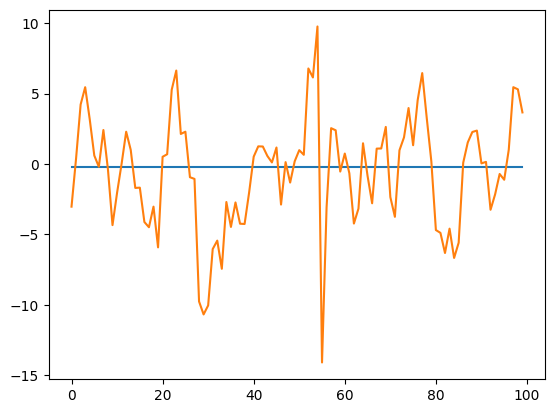

In [75]:
import matplotlib.pyplot as plt 

plt.plot(preds_y_train[:100])
plt.plot(preds_train[:100])
plt.show()

In [73]:
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')
print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 5.943776795293781
Test Set:
Mean Absolute Error (MAE): 5.708380997434137
